**Оглавление**
1. [Формулировка задачи](#task_description)
2. [Открытие данных](#start)
3. [Первичная обработка данных](#preprocessing)
    * [Корректировка трудового стажа](#employed)
    * [Корректировка уровня доходов](#income)
    * [Работа с дубликатами](#duplicates)
4. [Анализ факторов влияния на возврат кредита](#analysis)
    * [Цели получения кредита](#purpose) 
    * [Наличие детей](#kids)
    * [Семейное положение](#family)
    * [Доходы](#income_inf)
5. [Выводы](#inference)

<a id="task_description"></a> 
**Формулировка задачи**\
Заказчик - кредитный отдел банка. Необходимо выявить влияние следующих факторов на возврат кредита в срок:
* семейное положение,
* наличие и количество детей,
* цель получения кредита,
* уровень дохода.

<a id="start"></a> 
**Открытие данных**

In [217]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')

In [218]:
path = 'C:\\Users\\admin\\Desktop\\Portfolio\\credit\\' # путь к файлу с исходными данными
data = pd.read_csv(path + 'data.csv')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Пропущены значения в столбцах days_employed и total_income

<a id="preprocessing"></a> 
**Первичная обработка данных**

In [220]:
print(data[np.logical_and(data['days_employed'].isna(), data['total_income'].isna())]) # вывод записей с пропусками

       children  days_employed  dob_years education  education_id  \
12            0            NaN         65   среднее             1   
26            0            NaN         41   среднее             1   
29            0            NaN         63   среднее             1   
41            0            NaN         50   среднее             1   
55            0            NaN         54   среднее             1   
...         ...            ...        ...       ...           ...   
21489         2            NaN         47   Среднее             1   
21495         1            NaN         50   среднее             1   
21497         0            NaN         48    ВЫСШЕЕ             0   
21502         1            NaN         42   среднее             1   
21510         2            NaN         28   среднее             1   

               family_status  family_status_id gender  income_type  debt  \
12          гражданский брак                 1      M    пенсионер     0   
26           женат 

Пропущенные значения в столбцах days_employed и total_income у одних и тех же клиентов. Совпадение 100%. Вероятно, эти клиенты получили кредит без подтверждения дохода.

<a id="employed"></a> 
**Корректировка трудового стажа**

Text(0.5, 1.0, 'Распределение общего трудового стажа, дни')

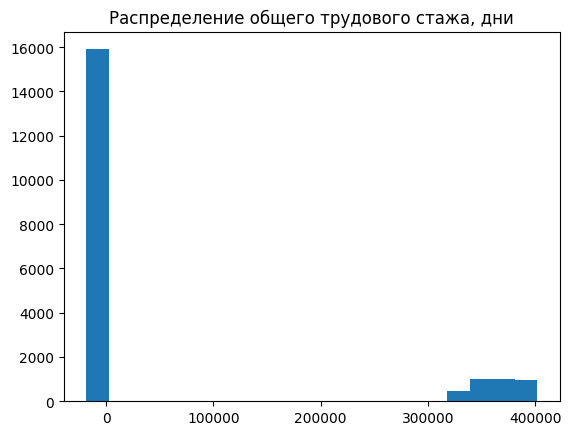

In [221]:
plt.hist(data['days_employed'], bins = 20)
plt.title('Распределение общего трудового стажа, дни')

Большинство клиентов имеют отрицательное значение стажа, что, вероятно, вызвано ошибкой ввода.
Заменим отрицательные значения на положительные и округлим до целочисленного значения.
Помимо этого, необходимо исследование причин группировки большого количества клиентов в области 300-400 тыс. дней, что соответствует около 1 тыс. лет.

In [222]:
data['days_employed']=data['days_employed'].abs() 

In [223]:
len(data.query('days_employed > 100000'))# количество клиентов с аномально большим стажем

3445

In [249]:
print(data.query('days_employed >= 0')['income_type'].value_counts()) # количество записей по типам занятости

income_type
сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: count, dtype: int64


In [225]:
print(data.query('days_employed > 100000').agg({'income_type':pd.Series.unique}))

income_type    [пенсионер, безработный]
dtype: object


In [226]:
print(data['income_type'].value_counts())

income_type
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: count, dtype: int64


Для 411 пенсионеров days_employed не указано (значения пропущены).

(array([342., 366., 347., 342., 325., 371., 346., 321., 327., 356.]),
 array([328728.72060452, 336031.3885916 , 343334.05657868, 350636.72456576,
        357939.39255284, 365242.06053992, 372544.72852701, 379847.39651409,
        387150.06450117, 394452.73248825, 401755.40047533]),
 <BarContainer object of 10 artists>)

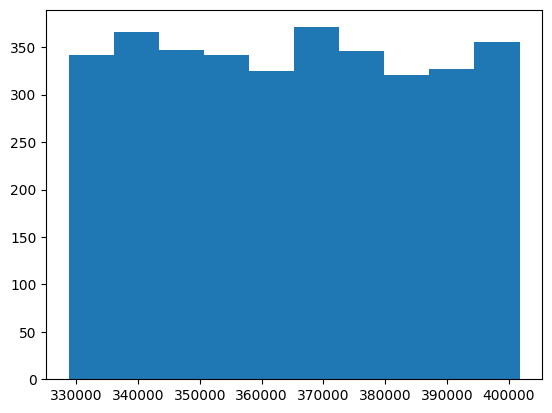

In [227]:
plt.hist(data.query('income_type=="пенсионер"')['days_employed'], bins = 10) # распределение аномально высоких значений стажа

(array([8.739e+03, 4.085e+03, 1.686e+03, 6.520e+02, 3.790e+02, 1.950e+02,
        1.110e+02, 4.400e+01, 1.200e+01, 3.000e+00]),
 array([   24.14163324,  1860.62245997,  3697.10328671,  5533.58411344,
         7370.06494017,  9206.5457669 , 11043.02659364, 12879.50742037,
        14715.9882471 , 16552.46907384, 18388.94990057]),
 <BarContainer object of 10 artists>)

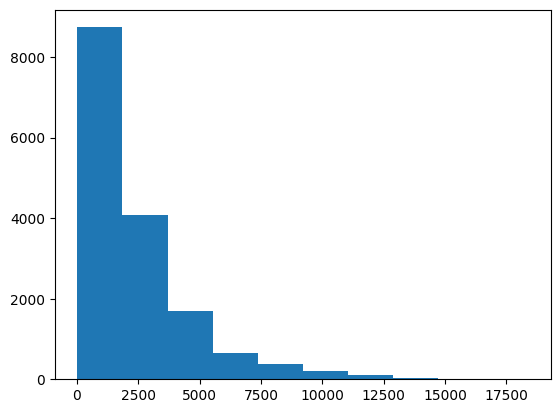

In [228]:
plt.hist(data.query('days_employed < 100000')['days_employed']) # распределение величин стажа без учета аномально высоких значений

In [229]:
avg_days_emp = data.query('days_employed < 100000')['days_employed'].mean() # средний стаж без учета аномалий

(array([8.739e+03, 7.530e+03, 1.686e+03, 6.520e+02, 3.790e+02, 1.950e+02,
        1.110e+02, 4.400e+01, 1.200e+01, 3.000e+00]),
 array([   24.14163324,  1860.62245997,  3697.10328671,  5533.58411344,
         7370.06494017,  9206.5457669 , 11043.02659364, 12879.50742037,
        14715.9882471 , 16552.46907384, 18388.94990057]),
 <BarContainer object of 10 artists>)

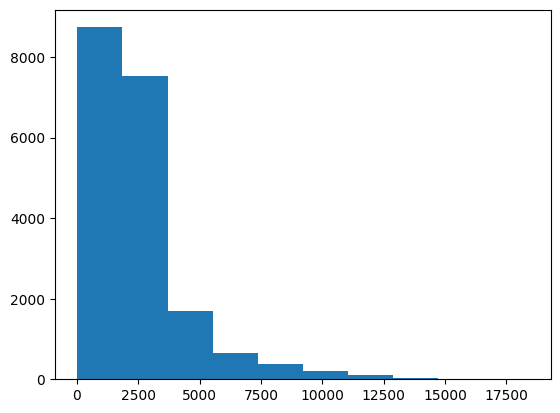

In [230]:
data['days_employed'] = np.where(data['days_employed'] > 100000, avg_days_emp, data['days_employed'])
plt.hist(data['days_employed'])

In [231]:
data['days_employed']=data['days_employed'].fillna(value = avg_days_emp)# замена отсутвующих значений средним
data['total_income']=data['total_income'].fillna(value = data['total_income'].mean()) # замена отсутвующих значений средним

<a id="income"></a> 
**Корректировка уровня доходов**

In [232]:
data['total_income']=data['total_income'].fillna(value = data['total_income'].mean()) # замена отсутвующих значений средним

In [233]:
data.info() # пропущенных значений больше нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [234]:
data['days_employed']=data['days_employed'].astype('int64')
data['total_income']=data['total_income'].astype('int64')

<a id="duplicates"></a> 
**Работа с дубликатами**

In [235]:
len(data[data.duplicated(keep = False)]) # количество дубликатов

106

In [236]:
data[data.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2353,41,среднее,1,женат / замужем,0,F,сотрудник,0,167422,покупка жилья для семьи
4182,1,2353,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,167422,свадьба
4851,0,2353,60,среднее,1,гражданский брак,1,F,пенсионер,0,167422,свадьба
5557,0,2353,58,среднее,1,гражданский брак,1,F,пенсионер,0,167422,сыграть свадьбу
7808,0,2353,57,среднее,1,гражданский брак,1,F,пенсионер,0,167422,на проведение свадьбы
8583,0,2353,58,высшее,0,Не женат / не замужем,4,F,пенсионер,0,167422,дополнительное образование
9238,2,2353,34,среднее,1,женат / замужем,0,F,сотрудник,0,167422,покупка жилья для сдачи
9528,0,2353,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,167422,операции со своей недвижимостью
9627,0,2353,56,среднее,1,женат / замужем,0,F,пенсионер,0,167422,операции со своей недвижимостью
10462,0,2353,62,среднее,1,женат / замужем,0,F,пенсионер,0,167422,покупка коммерческой недвижимости


Примечательно, что все дубликаты без просрочки долга. Дубликаты могли возникнуть из-за ошибок ввода.

In [237]:
data.drop_duplicates(inplace = True) #удаление дубликатов
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21471 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21471 non-null  int64 
 1   days_employed     21471 non-null  int64 
 2   dob_years         21471 non-null  int64 
 3   education         21471 non-null  object
 4   education_id      21471 non-null  int64 
 5   family_status     21471 non-null  object
 6   family_status_id  21471 non-null  int64 
 7   gender            21471 non-null  object
 8   income_type       21471 non-null  object
 9   debt              21471 non-null  int64 
 10  total_income      21471 non-null  int64 
 11  purpose           21471 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


<a id="purpose"></a> 
**Цели получения кредита**

In [238]:
data['purpose'].value_counts()

purpose
свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образовани

In [239]:
def conv(phrase):
            if 'свадьб' in phrase:
                return 'свадьба'
            if 'недвиж' in phrase:
                return 'недвижимость'
            if 'автомоб' in phrase:
                return 'автомобиль'
            if 'жиль' in phrase:
                return 'недвижимость'
            if 'образован' in phrase:
                return 'образование'
            else:
                return phrase

print(conv('сыграть свадьба'))

свадьба


In [240]:
data['category']=data['purpose'].apply(conv)

In [241]:
data['category'].value_counts()

category
недвижимость    10814
автомобиль       4308
образование      4014
свадьба          2335
Name: count, dtype: int64

In [242]:
purp_inf = data.groupby(by = 'category').agg({'dob_years':'count','debt':'sum'}).reset_index()
purp_inf.columns=['purp_cat','tot_num','not_return']
purp_inf['percent'] = purp_inf['not_return']/purp_inf['tot_num']
print(purp_inf)

       purp_cat  tot_num  not_return   percent
0    автомобиль     4308         403  0.093547
1  недвижимость    10814         782  0.072314
2   образование     4014         370  0.092177
3       свадьба     2335         186  0.079657


Диапазон невозврата - от 7,2% на недвижимость до 9,3% на автомобиль.

<a id="kids"></a> 
**Наличие детей**

In [243]:
data['children']=data['children'].abs()
kids_inf = data.groupby(by = 'children').agg({'dob_years':'count','debt':'sum'}).reset_index()
kids_inf.columns = ['children','tot_num','not_return']
kids_inf['percent']=kids_inf['not_return']/kids_inf['tot_num']

def chil (x):
    if x == 0:
        return 0
    else:
        return 1

kids_inf['categ']=kids_inf['children'].apply(chil)
print(kids_inf)

   children  tot_num  not_return   percent  categ
0         0    14107        1063  0.075353      0
1         1     4856         445  0.091639      1
2         2     2052         194  0.094542      1
3         3      330          27  0.081818      1
4         4       41           4  0.097561      1
5         5        9           0  0.000000      1
6        20       76           8  0.105263      1


In [244]:
kids_inf2=kids_inf.groupby(by = 'categ').agg({'tot_num':'sum','not_return':'sum'}) # влияние наличия детей на невозврат (1 - дети есть, 0 - детей нет)
kids_inf2['percent']= kids_inf['not_return']/kids_inf['tot_num']# процент невозврата
print(kids_inf2)

       tot_num  not_return   percent
categ                               
0        14107        1063  0.075353
1         7364         678  0.091639


Вывод: наличие детей увеличивает вероятность невозрата на 1,6%, что выглядит правдоподобным в связи с наличием расходов на содержание детей.

<a id="family"></a>
**Семейное положение**

In [245]:
family_inf = data.groupby(by='family_status').agg({'dob_years':'count','debt':'sum'}).reset_index() # влияние семейного статуса на невозврат
family_inf.columns = ['status','tot_num','not_return']
family_inf['percent'] = family_inf['not_return']/family_inf['tot_num'] # процент невозврата
print(family_inf)

                  status  tot_num  not_return   percent
0  Не женат / не замужем     2810         274  0.097509
1              в разводе     1195          85  0.071130
2         вдовец / вдова      959          63  0.065693
3       гражданский брак     4163         388  0.093202
4        женат / замужем    12344         931  0.075421


Семейное положение существенно влияет на процент невозврата. Диапазон значений от 6,6% до 9,7%

<a id="income_inf"></a>
**Доходы**

(array([1.840e+02, 9.550e+02, 2.008e+03, 2.562e+03, 2.575e+03, 2.379e+03,
        4.228e+03, 1.534e+03, 1.167e+03, 9.250e+02, 7.470e+02, 5.520e+02,
        3.350e+02, 2.880e+02, 2.290e+02, 1.640e+02, 1.250e+02, 9.400e+01,
        8.200e+01, 5.200e+01, 5.100e+01, 3.900e+01, 2.800e+01, 2.700e+01,
        1.800e+01, 1.400e+01, 1.000e+01, 1.100e+01, 1.100e+01, 1.400e+01,
        1.000e+01, 4.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 6.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

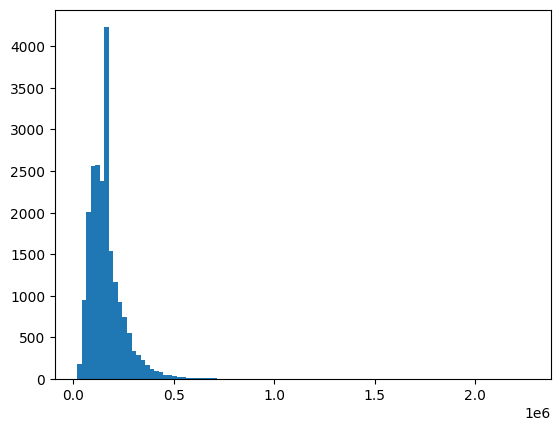

In [246]:
plt.hist(data['total_income'], bins = 100)

In [247]:
np.percentile(data['total_income'], [25,50,75,90,95])

array([107654.5, 156105. , 195751.5, 269784. , 331463. ])

In [248]:
def money(x):
    if x<=100000:
        return '<100 тыс.'
    elif x <=150000:
        return '<150 тыс.'
    elif x <= 200000:
        return '<200 тыс.'
    else:
        return '>200 тыс.'

data['money_cat'] = data['total_income'].apply(money)
mon_inf = data.groupby(by = 'money_cat').agg({'dob_years':'count','debt':'sum'}).reset_index()
mon_inf.columns=['money_cat','tot_num','not_return']
mon_inf['percent'] = mon_inf['not_return']/mon_inf['tot_num'] # процент невозврата
print(mon_inf)

   money_cat  tot_num  not_return   percent
0  <100 тыс.     4463         354  0.079319
1  <150 тыс.     5704         491  0.086080
2  <200 тыс.     6238         538  0.086246
3  >200 тыс.     5066         358  0.070667


При доходах от 100 до 200 тыс. вероятность невозврата максимальна, что не выглядит очевидным.

<a id="inference"></a>
**Выводы**

1. Диапазон невозврата кредита в зависимости от целей его получения составляет: от 7,2% (на недвижимость) до 9,3% (на автомобиль).
2. Наличие детей увеличивает вероятность невозрата на 1,6%
3. Семейное положение существенно влияет на процент невозврата. Диапазон значений от 6,6% (для вдовцов) до 9,7% (для не вступившх в брак).
4. При доходах от 100 до 200 тыс. вероятность невозврата максимальна и составляет 8,6%.